In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [11]:
# Use Inspector to print the column names and types for the Measurement dictionary
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
engine.execute('SELECT * FROM station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [13]:
# Use Inspector to print the column names and types for the station dictionary
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#Find the last date in measurement
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [19]:
# Calculate the date 1 year ago from the last data point in the database
twelve_months = dt.date(2017,8,23) - dt.timedelta(days=365)
twelve_months

datetime.date(2016, 8, 23)

# Exploratory Climate Analysis

In [20]:
# Perform a query to retrieve the data and find the station with the most rain on any given day

percip = session.query(Measurement.date, func.max(Measurement.prcp).label("most rain")).\
filter(Measurement.date > f"{twelve_months}").\
group_by(Measurement.date).\
order_by(Measurement.date).all()

In [21]:
#Convert to a dataframe
percip_df = pd.DataFrame(percip, columns =['date', 'percipitation'])
percip_df.set_index('date', inplace=True)
percip_df.head(25)

,percipitation
date,
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
2016-08-28,2.07
2016-08-29,0.90
2016-08-30,0.05
2016-08-31,2.46
2016-09-01,0.02


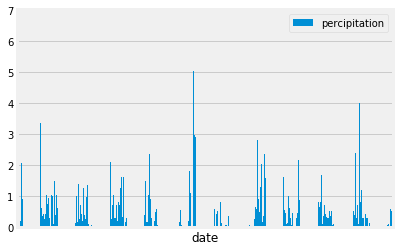

In [22]:
# Use Pandas Plotting with Matplotlib to plot the data
percip_df.plot.bar(grid=True)
plt.tight_layout

#remove xtick labels and show plot
plt.xticks([],[])
plt.show()


In [23]:
# Design a query to show how many stations are available in this dataset?
no_stations = session.query(func.count(distinct(Station.name))).all()
no_stations

[(9)]

In [24]:
# What are the most active stations? (i.e. what station has the most rows)?  Sort by most active to least
weather = session.query(Measurement.station, Station.name, func.count(Measurement.station)).\
filter(Measurement.station == Station.station).\
order_by(func.count(Measurement.station).desc()).\
group_by(Station.name).all()

#Convert to a dateframe
weather_df=pd.DataFrame(weather, columns = ['station id', 'name', 'activity'])

#Select the the most active station and show the dataframe
most_active=weather_df.iloc[0,0]
print(f"Station {most_active} is the most active")
weather_df.head()

Station USC00519281 is the most active


,station id,name,activity
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612


In [25]:
# Using the station id from the previous query, calculate the lowest, highest and average temperature recorded. 

temp_stats = session.query(Measurement.station, 
                           func.min(Measurement.tobs), 
                           func.max(Measurement.tobs),
                           func.avg(Measurement.tobs)).\
filter(Measurement.station == most_active).all()
temp_stats_df = pd.DataFrame(temp_stats, columns = ['station id','lowest temp', 'highest temp', 'average temp'])
temp_stats_df.head()


,station id,lowest temp,highest temp,average temp
0,USC00519281,54.0,85.0,71.663781


In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
active_station = session.query(Measurement.tobs).\
filter(Measurement.station == most_active).all()
active_station_df = pd.DataFrame(active_station, columns = ['temperature'])
active_station_df.head()


,temperature
0,70.0
1,62.0
2,74.0
3,75.0
4,74.0


In [27]:
active_station_df.count()

temperature    2772
dtype: int64

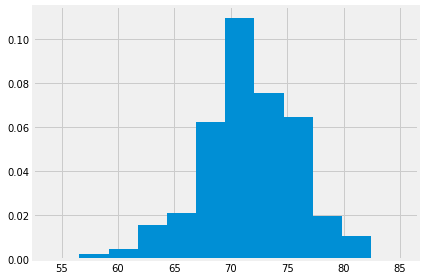

In [28]:
#Plot the histogram
plt.hist(active_station_df["temperature"], bins=12, 
         density = 1,
         edgecolor='none')
plt.tight_layout()

#plt.ylabel('Frequency')
plt.show()

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
yr_ago_start = start_date - dt.timedelta(days=365)
yr_ago_start
print(calc_temps_last_year())


NameError: name 'start_date' is not defined

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
